# Collaborative Environment - Tennis
Author: Gerti Tuzi


[DDPG]: https://arxiv.org/pdf/1509.02971.pdf
[MADDPG]: https://arxiv.org/pdf/1706.02275.pdf
[PSNE]: https://arxiv.org/pdf/1706.01905.pdf
[Layer Normalization]: https://arxiv.org/abs/1607.06450

##### Foreword
In the Tennis game, the desired outcome of the solution is the maximization of either player's score.
Since this score is maximized when the ball is kept in play, the maximization of the desired overall goal aligns with the maximization of each player's rewards.
Thus this is a *collaborative* environment.

In [1]:
import os
import numpy as np
import random
from tqdm import tqdm
from utils.buffer import ReplayBuffer
from utils.utilities import list_to_tensor, partial_obs_2_full_state
from tensorboardX import SummaryWriter
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import math
import torch

#### Utility functions

In [2]:
def get_env():
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="./envs/Tennis_Linux/Tennis.x86_64", no_graphics = True)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="./envs/Tennis.app", no_graphics = False)
    return env

def welcome():
    env = get_env()

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)

    # size of each action
    action_size = brain.vector_action_space_size

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('Number of agents:', num_agents)
    print('Size of each action:', action_size)
    print('There are {} agents. \n  Each agent observes a state with length: {}'.format(states.shape[0], state_size))

    return env, state_size, action_size, brain_name, num_agents


def create_logdirs(subfolder = ''):
    return os.getcwd() + "/log/" + subfolder, os.getcwd() + "/model_dir/" + subfolder

In [3]:
number_of_episodes = 2000
seed = 0
env, state_size, action_size, brain_name, num_agents = welcome()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. 
  Each agent observes a state with length: 24


[DDPG]: https://arxiv.org/pdf/1509.02971.pdf
[MADDPG]: https://arxiv.org/pdf/1706.02275.pdf
## SADDPG
#### *Adapted [DDPG] for multiagent environment*
Here I train only one agent to play both players. Since [DDPG] trains one agent (i.e. one network), it is necessary to adapt the agent to be aware of which role it is under at any given time. Additionally, if we define the full state of the environement as the combined knowledge of both players' states, then each player *partially* observes the environment. Therefore this setup does not fit out-of-the-box with the original formulation of [DDPG].
So, the following adjustments were made to [DDPG] to accomodate the multi-agent scenario:
* The critic inputs the full environment state, which is the concatenation of the partial observed states from each player.
* For the Tennis environment, since we have 2 players, the full observed state input into the action value function (Q) is flipped, depending on the player role the agent takes. This way gives the agent awareness of the role.
* Use one policy function, which takes the partial observations of each player accordingly - given a particular role.
* Replay buffer does not make a distinction between each player's transitions. However, for each transition, the full observations are adapted for each player before being inserted into the buffer. This means that a full observation is inserted twice, but one of them is flipped. Alternatively, partial observations for each player could be marked, but then the algorithm would need to be modified to accomodate the gradients for each player. The former method requires less code manipulation.

Since under the multi-agent environment this variant of DDPG uses a single agent, I am referring to it as *SADDPG* to differentiate it from *[MADDPG]*


#### Solution: environment was solved in 259 episodes

In [4]:
from agents.saddpg import SADDPG

In [5]:
def train_saddpg(env, saddpg,number_of_episodes, logger, episode_length=500, batchsize = 512):
    torch.set_num_threads(1)
    buffer = ReplayBuffer(int(1e6))

    # decaying amplitude of OU noise
    noise = 1.
    noise_reduction = 0.99995
    t = 0

    agent0_reward = []
    agent1_reward = []
    score = np.zeros(shape=(number_of_episodes,))
    avg_score_100 = []

    LEARN_EVERY = 1
    LEARNING_CYCLES = 1

    best_score = -math.inf
    env_solved = False
    transitions_count = 0
    
    transitions_per_update = int(batchsize * 0.1)

    for episode in range(0, number_of_episodes):
        reward_this_episode = np.zeros((1, num_agents))
        env_info = env.reset(train_mode=True)
        obs = env_info[brain_name].vector_observations
        obs_full = partial_obs_2_full_state(obs.tolist())

        # Reset the noise
        saddpg.reset()

        max_reward = -math.inf
        for episode_t in range(episode_length):
            t += 1

            # explore = only explore for a certain number of episodes
            actions = []
            for ai in range(num_agents):
                _obs = obs.tolist()[ai]
                _obs = torch.tensor(_obs, dtype=torch.float)
                a = saddpg.act(_obs, noise=noise)
                actions.append(a.detach().numpy())
            noise = max(noise * noise_reduction, 0.05)

            # step forward one frame
            env_info = env.step(np.vstack(actions))[brain_name]
            next_obs = env_info.vector_observations  # get next state (for each agent)
            next_full_obs = partial_obs_2_full_state(next_obs.tolist())
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            reward_this_episode += rewards

            # Create transitions. Since we have 2 agents, there will be 2 transitions
            for ai in range(num_agents):
                # add data to buffer, individually for each agent
                transition = (np.array(obs.tolist()[ai], dtype=np.float32),
                              np.array(obs_full if ai == 0 else list(reversed(obs_full)), dtype=np.float32),
                              np.array(actions[ai], dtype=np.float32),
                              np.array(rewards[ai], dtype=np.float32)[None],
                              np.array(next_obs.tolist()[ai], dtype=np.float32),
                              np.array(next_full_obs if ai == 0 else list(reversed(next_full_obs)), dtype=np.float32),
                              np.array(dones[ai], dtype=np.float32)[None])
                
                buffer.push(transition)
                transitions_count += 1

            obs, obs_full = next_obs, next_full_obs
            if np.any(np.array(rewards) > max_reward):
                max_reward = float(np.max(rewards))

            # ---------- Learning ----------- #
            if ((transitions_count+1) % transitions_per_update == 0):
                transitions_count = 0
                if len(buffer) > batchsize and episode % LEARN_EVERY == 0:
                    for _ in range(LEARNING_CYCLES):
                        samples = buffer.sample(batchsize)
                        saddpg.learn(samples)
                    # Soft update
                    saddpg.update_targets()

        agent0_reward.append(reward_this_episode[0, 0])
        agent1_reward.append(reward_this_episode[0, 1])

        # Score is defined as the max un-discounted return from each of the players
        score[episode] = np.max((reward_this_episode[0, 0], reward_this_episode[0, 1]))
        avg_score_100.append(np.mean(score[np.max((0, episode - 100 + 1)):episode]))

        str2print = str('\rEpisode: {}' + '\t100-episode avg score: {:.2f}'+
                        '\tScore: {:.2f}' + '\tNoise: {:.2f}' +
                        '\tMax.reward: {:.3f}').format(episode,avg_score_100[episode],
                                                       float(score[episode]), noise, max_reward)

        print(str2print, end= "\n" if (episode+1) % 100 == 0 else "")

        # ---------- Logging ------------- #
        if (episode % 1 == 0 or episode == number_of_episodes - 1) and (episode > 1):
            avg_rewards = [np.mean(agent0_reward[episode - 100:episode]), np.mean(agent1_reward[episode - 100:episode])]
            _avg_score_100 = np.mean(score[episode - 100:episode])
            for a_i, avg_rew in enumerate(avg_rewards):
                logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)

            logger.add_scalar('Avg.Score-100Episodes', _avg_score_100, episode)

        if best_score < float(score[episode]):
            print('\nBest score improved: {:.2f}'.format(float(score[episode])))
            # Score has improved
            best_score = float(score[episode])
            torch.save(saddpg.saddpg_agent.actor.state_dict(), 'model_dir/SADDPG/actor.pth')
            torch.save(saddpg.saddpg_agent.critic.state_dict(), 'model_dir/SADDPG/critic.pth')
            torch.save(saddpg.saddpg_agent.target_actor.state_dict(), 'model_dir/SADDPG/target_actor.pth')
            torch.save(saddpg.saddpg_agent.target_critic.state_dict(), 'model_dir/SADDPG/target_critic.pth')

        if not env_solved and (avg_score_100[episode] > 0.5) and (episode > 99):
            print('\nEnvironment solved in {} episodes'.format(episode))
            env_solved = True
            
    return avg_score_100, agent0_reward, agent1_reward


In [6]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# -------------
log_path, model_dir = create_logdirs('SADDPG')
os.makedirs(model_dir, exist_ok=True)
logger = SummaryWriter(log_dir=log_path)
# -------------
saddpg = SADDPG(partial_obs_size = state_size,
                action_size = action_size,
                full_obs_size = state_size*num_agents,
                logger=logger)

In [7]:
avg_score_100, agent0_reward, agent1_reward = train_saddpg(env, saddpg, number_of_episodes, logger)
logger.close()

/home/gtuzi/.conda/envs/rl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gtuzi/.conda/envs/rl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0	100-episode avg score: nan	Score: 0.22	Noise: 0.98	Max.reward: 0.100
Best score improved: 0.22
Episode: 14	100-episode avg score: -0.10	Score: 0.73	Noise: 0.69	Max.reward: 0.1000
Best score improved: 0.73
Episode: 51	100-episode avg score: -0.10	Score: 0.85	Noise: 0.27	Max.reward: 0.1000
Best score improved: 0.85
Episode: 53	100-episode avg score: -0.07	Score: 0.95	Noise: 0.26	Max.reward: 0.100
Best score improved: 0.95
Episode: 58	100-episode avg score: 0.01	Score: 0.99	Noise: 0.23	Max.reward: 0.1000
Best score improved: 0.99
Episode: 62	100-episode avg score: 0.06	Score: 1.07	Noise: 0.21	Max.reward: 0.100
Best score improved: 1.07
Episode: 99	100-episode avg score: 0.16	Score: -0.17	Noise: 0.08	Max.reward: 0.000
Episode: 185	100-episode avg score: 0.09	Score: 1.09	Noise: 0.05	Max.reward: 0.1000
Best score improved: 1.09
Episode: 199	100-episode avg score: 0.21	Score: 0.22	Noise: 0.05	Max.reward: 0.100
Episode: 259	100-episode avg score: 0.50	Score: 0.85	Noise: 0.05	Max.rew

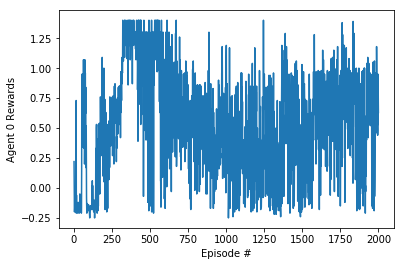

In [8]:
plt.plot(np.arange(1, len(agent0_reward)+1), [np.mean(s) for s in agent0_reward])
plt.ylabel('Agent 0 Rewards')
plt.xlabel('Episode #')
plt.show()

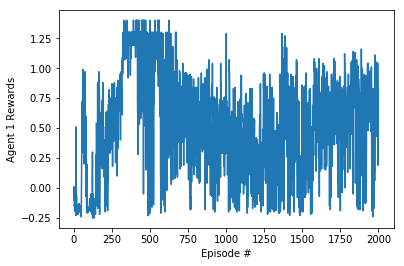

In [9]:
plt.plot(np.arange(1, len(agent1_reward)+1), [np.mean(s) for s in agent1_reward])
plt.ylabel('Agent 1 Rewards')
plt.xlabel('Episode #')
plt.show()

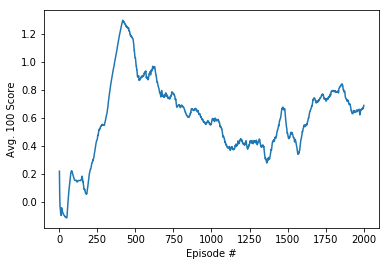

In [10]:
plt.plot(np.arange(1, len(avg_score_100)+1), [np.mean(s) for s in avg_score_100])
plt.ylabel('Avg. 100 Score')
plt.xlabel('Episode #')
plt.show()

---

# MADDPG
[MADDPG]: https://arxiv.org/pdf/1706.02275.pdf

#### [MADDPG]
[MADDPG] implements decentralized actors with centralized critics. This means that each agent has its own policy, each with its partial observations of the environment, and a dedicated all-knowing critic guiding it in the right direction. "All-knowing" here means that each agent's critic inputs the full environment state, as well as all actions from all the agents in the game, and output the expected value for each agent.
However the gradients, and consequently the updates, are taken with respect to the parameters of the particular agent's critic parameters.

Since each agent has its own policy and value function, [MADDPG] allows the arbitrary structuring of the reward system for each agent.
This way we could have a competitive or collaborative setting. Under the Tennis environment we have a collaborative environment since the maximization of both actors's score maximizes the desired overall score (i.e. this is not a zero-sum game).


#### Solution: environement was solved in 290 episodes

In [4]:
from agents.maddpg import MADDPG

In [5]:
def train_maddpg(env, maddpg, number_of_episodes, logger, episode_length=500, batchsize = 512):
    parallel_envs = 1
    episode_per_update = 2 * parallel_envs
    torch.set_num_threads(parallel_envs)

    buffer = ReplayBuffer(int(1e6))

    # decaying amplitude of OU noise
    noise = 1.
    noise_reduction = 0.99995
    t = 0

    agent0_reward = []
    agent1_reward = []
    score = np.zeros(shape=(number_of_episodes,))
    avg_score_100 = []

    LEARN_EVERY = 1
    LEARNING_CYCLES = 1

    best_score = -math.inf
    env_solved = False
    transitions_count = 0

    episode_per_update = 1
    transitions_per_update = int(batchsize * 0.1) # 10% of batch size. This is the novelty fraction

    # use keep_awake to keep workspace from disconnecting
    for episode in range(0, number_of_episodes, parallel_envs):
        reward_this_episode = np.zeros((parallel_envs, num_agents))
        env_info = env.reset(train_mode=True)
        obs = env_info[brain_name].vector_observations
        obs_full = partial_obs_2_full_state(obs.tolist())

        # Reset the noise
        maddpg.reset()
        max_reward = -math.inf
        
        for episode_t in range(episode_length):
            t += parallel_envs # time increment depends on number of parallel environments
            
            actions = maddpg.act(list_to_tensor(obs.tolist()), noise=noise)
            noise = max(noise * noise_reduction, 0.05) # Clip exploration ... always a bit curious !!!
            actions = torch.stack(actions).detach().cpu().numpy()

            # step forward one frame
            env_info = env.step(actions)[brain_name]
            next_obs = env_info.vector_observations  # get next state (for each agent)
            next_full_obs = partial_obs_2_full_state(next_obs.tolist())
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            reward_this_episode += rewards

            # add data to buffer
            transition = (np.array(obs),
                          np.array(obs_full),
                          np.array(actions),
                          np.array(rewards),
                          np.array(next_obs),
                          np.array(next_full_obs),
                          np.array(dones))
            
            buffer.push(transition)
            transitions_count += 1

            if np.any(np.array(rewards) > max_reward):
                max_reward = float(np.max(rewards))

            # ---------- Learning ----------- #
            # update once after every episode_per_update
            if ((transitions_count+1) % transitions_per_update == 0):
                transitions_count = 0
                if len(buffer) > batchsize and episode % LEARN_EVERY == 0: # episode % episode_per_update < parallel_envs:
                    # Each agent learns
                    for _ in range(LEARNING_CYCLES):
                        for a_i in range(num_agents):
                            samples = buffer.sample(batchsize)
                            maddpg.learn(samples, a_i)

                    # soft update the target networks towards the actual networks
                    maddpg.update_targets()
            
            obs, obs_full = next_obs, next_full_obs

            
        for i in range(parallel_envs):
            agent0_reward.append(reward_this_episode[i, 0])
            agent1_reward.append(reward_this_episode[i, 1])

            # Score is defined as the max un-discounted return from each of the players from
            # a given episode
            score[episode] = np.max((reward_this_episode[i, 0], reward_this_episode[i, 1]))
            avg_score_100.append(np.mean(score[np.max((0, episode - 100 + 1)):episode]))

        str2print = str('\rEpisode: {}' +
                        '\t100-episode avg score: {:.2f}'+
                        '\tScore: {:.2f}' +
                        '\tNoise: {:.2f}' +
                        '\tMax.reward: {:.3f}').format(episode, avg_score_100[episode],
                                                        float(score[episode]),noise, max_reward)

        print(str2print, end= "\n" if (episode+1) % 100 == 0 else "")

        # ---------- Logging ------------- #
        if (episode % 1 == 0 or episode == number_of_episodes - 1) and (episode > 1):
            avg_rewards = [np.mean(agent0_reward[episode - 100:episode]), np.mean(agent1_reward[episode - 100:episode])]
            _avg_score_100 = np.mean(score[episode - 100:episode])
            for a_i, avg_rew in enumerate(avg_rewards):
                logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)
            logger.add_scalar('Avg.Score-100Episodes', _avg_score_100, episode)

        if best_score < float(score[episode]):
            print('\nBest score improved: {:.2f}'.format(float(score[episode])))
            # Score has improved
            best_score = float(score[episode])
            for ai in range(num_agents):
                torch.save(maddpg.maddpg_agent[ai].actor.state_dict(), 'model_dir/MADDPG/actor_{}.pth'.format(ai))
                torch.save(maddpg.maddpg_agent[ai].critic.state_dict(), 'model_dir/MADDPG/critic_{}.pth'.format(ai))
                torch.save(maddpg.maddpg_agent[ai].target_actor.state_dict(), 'model_dir/MADDPG/target_actor_{}.pth'.format(ai))
                torch.save(maddpg.maddpg_agent[ai].target_critic.state_dict(), 'model_dir/MADDPG/target_critic_{}.pth'.format(ai))

        if not env_solved and (avg_score_100[episode] > 0.5) and (episode > 99):
            print('\nEnvironment solved in {} episodes'.format(episode))
            env_solved = True
            
        
    return avg_score_100, agent0_reward, agent1_reward

In [6]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# ---------------
log_path, model_dir = create_logdirs('MADDPG')
os.makedirs(model_dir, exist_ok=True)
logger = SummaryWriter(log_dir=log_path)
# ---------------
maddpg = MADDPG(n_agents = num_agents, 
                partial_obs_size = state_size,
                action_size = action_size, 
                full_obs_size = state_size*num_agents,
                logger=logger)

In [7]:
avg_score_100, agent0_reward, agent1_reward = train_maddpg(env, maddpg, number_of_episodes, logger)
logger.close()

/home/gtuzi/.conda/envs/rl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gtuzi/.conda/envs/rl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0	100-episode avg score: nan	Score: 0.03	Noise: 0.98	Max.reward: 0.100
Best score improved: 0.03
Episode: 1	100-episode avg score: 0.03	Score: 0.23	Noise: 0.95	Max.reward: 0.100
Best score improved: 0.23
Episode: 34	100-episode avg score: -0.10	Score: 0.39	Noise: 0.42	Max.reward: 0.1000
Best score improved: 0.39
Episode: 35	100-episode avg score: -0.08	Score: 0.67	Noise: 0.41	Max.reward: 0.100
Best score improved: 0.67
Episode: 48	100-episode avg score: 0.01	Score: 0.76	Noise: 0.29	Max.reward: 0.10000
Best score improved: 0.76
Episode: 53	100-episode avg score: 0.03	Score: 0.80	Noise: 0.26	Max.reward: 0.1000
Best score improved: 0.80
Episode: 99	100-episode avg score: 0.10	Score: 0.08	Noise: 0.08	Max.reward: 0.1000
Episode: 171	100-episode avg score: 0.05	Score: 0.86	Noise: 0.05	Max.reward: 0.1000
Best score improved: 0.86
Episode: 182	100-episode avg score: 0.08	Score: 0.87	Noise: 0.05	Max.reward: 0.1000
Best score improved: 0.87
Episode: 196	100-episode avg score: 0.05	Score

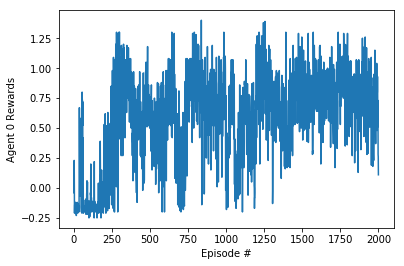

In [8]:
plt.plot(np.arange(1, len(agent0_reward)+1), [np.mean(s) for s in agent0_reward])
plt.ylabel('Agent 0 Rewards')
plt.xlabel('Episode #')
plt.show()

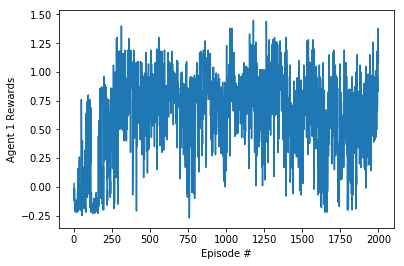

In [9]:
plt.plot(np.arange(1, len(agent1_reward)+1), [np.mean(s) for s in agent1_reward])
plt.ylabel('Agent 1 Rewards')
plt.xlabel('Episode #')
plt.show()

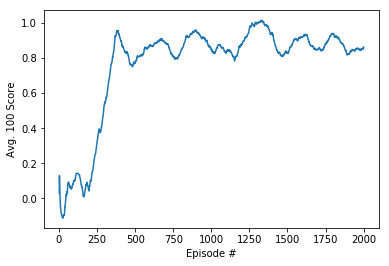

In [10]:
plt.plot(np.arange(1, len(avg_score_100)+1), [np.mean(s) for s in avg_score_100])
plt.ylabel('Avg. 100 Score')
plt.xlabel('Episode #')
plt.show()

---

# MADDPG with PSNE


[MADDPG]: https://arxiv.org/pdf/1706.02275.pdf
[PSNE]: https://arxiv.org/pdf/1706.01905.pdf
[Layer Normalization]: https://arxiv.org/abs/1607.06450


In the traditional [DDPG]/[MADDPG] exploration is usually achieved by perturbing the actions using Ornstein–Uhlenbeck process or just using Normal distribution. Under this approach, for a given policy we are not guaranteed consistent state transitions.
An alternative method to explore is by perturbing the parameters space of the policy. In [PSNE] the parameters of the layers of the network are perturbed by adding some measurable normal noise. Layer normalization is used between the hidden layers to achieve meaningful noise perturbation across the hidden layers.
Noise std. dev is adapted as learning progresses, since sensitivity of the network differs through this process. For more details refer to the paper.


#### Solution: environment was solved in 270 episodes

In [11]:
from agents.maddpg_psne import MADDPG_PSNE

In [12]:
def train_maddpg_psne(env, maddpg_psne, number_of_episodes, logger, episode_length = 500, batchsize = 512):
    parallel_envs = 1
    torch.set_num_threads(parallel_envs)

    buffer = ReplayBuffer(int(1e6))

    noise = 1.
    noise_reduction = 0.99995

    t = 0

    agent0_reward = []
    agent1_reward = []
    score = np.zeros(shape=(number_of_episodes,))
    avg_score_100 = []

    LEARN_EVERY = 1
    LEARNING_CYCLES = 1

    best_score = -math.inf
    env_solved = False
    transitions_count = 0
    transitions_per_update = int(batchsize*0.1)


    # use keep_awake to keep workspace from disconnecting
    for episode in range(0, number_of_episodes, parallel_envs):
        reward_this_episode = np.zeros((parallel_envs, num_agents))
        env_info = env.reset(train_mode=True)
        obs = env_info[brain_name].vector_observations
        obs_full = partial_obs_2_full_state(obs.tolist())

        # Reset the noise
        maddpg_psne.reset()
        max_reward = -math.inf

        for episode_t in range(episode_length):
            t += parallel_envs # time increment depends on number of parallel environments
            # Explore
            actions = maddpg_psne.act(list_to_tensor(obs.tolist()), use_perturbed_actor=True, noise_delta = noise)
            noise = max(noise * noise_reduction, 0.05)
            actions = torch.stack(actions).detach().numpy()

            # step forward one frame
            env_info = env.step(actions)[brain_name]
            next_obs = env_info.vector_observations  # get next state (for each agent)
            next_full_obs = partial_obs_2_full_state(next_obs.tolist())
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            reward_this_episode += rewards

            # add data to buffer
            transition = (np.array(obs),
                          np.array(obs_full),
                          np.array(actions),
                          np.array(rewards),
                          np.array(next_obs),
                          np.array(next_full_obs),
                          np.array(dones))
            buffer.push(transition)
            transitions_count += 1

            if np.any(np.array(rewards) > max_reward):
                max_reward = float(np.max(rewards))

            # ---------- Learning ----------- #
            # update once after every episode_per_update
            if ((transitions_count + 1) % transitions_per_update == 0):
                transitions_count = 0
                if len(buffer) > batchsize and episode % LEARN_EVERY == 0:
                    # Each agent learns
                    for _ in range(LEARNING_CYCLES):
                        for a_i in range(num_agents):
                            samples = buffer.sample(batchsize)
                            maddpg_psne.learn(samples, a_i)
                    # soft update the target networks towards the actual networks
                    maddpg_psne.update_targets()

            obs, obs_full = next_obs, next_full_obs

        # Perturb at the end of the episode, to explore next episode
        if len(buffer) > batchsize:
            samples = buffer.sample(batchsize)
            maddpg_psne.perturb_the_actors(samples)

        for i in range(parallel_envs):
            agent0_reward.append(reward_this_episode[i, 0])
            agent1_reward.append(reward_this_episode[i, 1])

            # Score is defined as the max un-discounted return from each of the players from a given episode
            score[episode] = np.max((reward_this_episode[i, 0], reward_this_episode[i, 1]))
            avg_score_100.append(np.mean(score[np.max((0, episode - 100 + 1)):episode]))

        str2print = str('\rEpisode: {}' +
                        '\t100-episode avg score: {:.2f}' +
                        '\tScore: {:.2f}' +
                        '\tNoise: {:.2f}' +
                        '\tMax.reward: {:.3f}').format(episode, avg_score_100[episode],
                                                       float(score[episode]), noise, max_reward)

        print(str2print, end="\n" if (episode + 1) % 100 == 0 else "")

        # ---------- Logging ------------- #
        if (episode % 1 == 0 or episode == number_of_episodes - 1) and (episode > 1):
            avg_rewards = [np.mean(agent0_reward[episode - 100:episode]), np.mean(agent1_reward[episode - 100:episode])]
            _avg_score_100 = np.mean(score[episode - 100:episode])
            for a_i, avg_rew in enumerate(avg_rewards):
                logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)
            logger.add_scalar('Avg.Score-100Episodes', _avg_score_100, episode)

        if best_score < float(score[episode]):
            print('\nBest score improved: {:.2f}'.format(float(score[episode])))
            # Score has improved
            best_score = float(score[episode])
            for ai in range(num_agents):
                torch.save(maddpg_psne.maddpg_agent[ai].actor.state_dict(), 'model_dir/MADDPG_PSNE/actor_{}.pth'.format(ai))
                torch.save(maddpg_psne.maddpg_agent[ai].critic.state_dict(), 'model_dir/MADDPG_PSNE/critic_{}.pth'.format(ai))
                torch.save(maddpg_psne.maddpg_agent[ai].target_actor.state_dict(), 'model_dir/MADDPG_PSNE/target_actor_{}.pth'.format(ai))
                torch.save(maddpg_psne.maddpg_agent[ai].target_critic.state_dict(), 'model_dir/MADDPG_PSNE/target_critic_{}.pth'.format(ai))

        if not env_solved and (avg_score_100[episode] > 0.5) and (episode > 99):
            print('\nEnvironment solved in {} episodes'.format(episode))
            env_solved = True

    return avg_score_100, agent0_reward, agent1_reward

In [13]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# ---------------
log_path, model_dir = create_logdirs('MADDPG_PSNE')
os.makedirs(model_dir, exist_ok=True)
logger = SummaryWriter(log_dir=log_path)
# ---------------
maddpg_psne = MADDPG_PSNE(n_agents = num_agents,
                          partial_obs_size = state_size,
                          action_size = action_size,
                          full_obs_size =state_size * num_agents,
                          logger=logger)

In [14]:
avg_score_100, agent0_reward, agent1_reward = train_maddpg_psne(env, maddpg_psne, number_of_episodes, logger)
logger.close()

Episode: 0	100-episode avg score: nan	Score: -0.15	Noise: 0.98	Max.reward: 0.000
Best score improved: -0.15
Episode: 1	100-episode avg score: -0.15	Score: -0.13	Noise: 0.95	Max.reward: 0.000
Best score improved: -0.13
Episode: 2	100-episode avg score: -0.14	Score: -0.02	Noise: 0.93	Max.reward: 0.100
Best score improved: -0.02
Episode: 12	100-episode avg score: -0.13	Score: 1.08	Noise: 0.72	Max.reward: 0.1000
Best score improved: 1.08
Episode: 39	100-episode avg score: -0.01	Score: 1.10	Noise: 0.37	Max.reward: 0.1000
Best score improved: 1.10
Episode: 99	100-episode avg score: -0.01	Score: -0.14	Noise: 0.08	Max.reward: 0.000
Episode: 117	100-episode avg score: -0.03	Score: 1.20	Noise: 0.05	Max.reward: 0.1000
Best score improved: 1.20
Episode: 120	100-episode avg score: -0.02	Score: 1.30	Noise: 0.05	Max.reward: 0.1000
Best score improved: 1.30
Episode: 199	100-episode avg score: 0.19	Score: -0.06	Noise: 0.05	Max.reward: 0.1000
Episode: 270	100-episode avg score: 0.50	Score: 0.88	Noise: 0

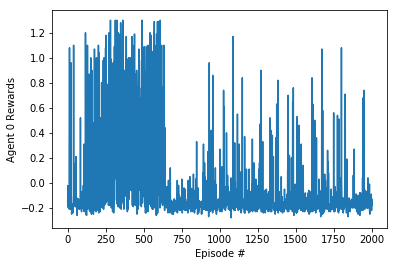

In [15]:
plt.plot(np.arange(1, len(agent0_reward)+1), [np.mean(s) for s in agent0_reward])
plt.ylabel('Agent 0 Rewards')
plt.xlabel('Episode #')
plt.show()

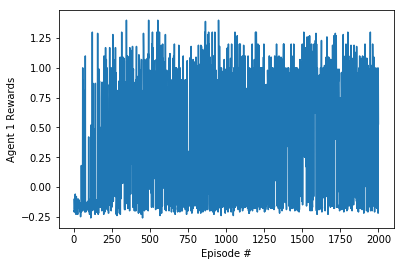

In [16]:
plt.plot(np.arange(1, len(agent1_reward)+1), [np.mean(s) for s in agent1_reward])
plt.ylabel('Agent 1 Rewards')
plt.xlabel('Episode #')
plt.show()

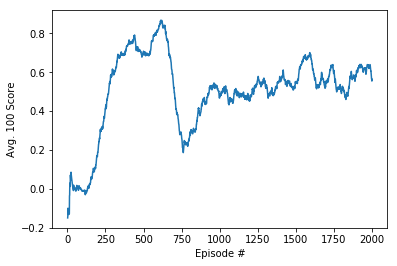

In [17]:
plt.plot(np.arange(1, len(avg_score_100)+1), [np.mean(s) for s in avg_score_100])
plt.ylabel('Avg. 100 Score')
plt.xlabel('Episode #')
plt.show()

In [18]:
env.close()

## Other



#### Network Topologies
The Actor/Critic networks consisted of MLPs, each with 2 hidden layers with 256 units each. Actors use [Layer Normalization].

##### Hyperparameters and devil-in-detail tricks
Discount factor (gamma) used is 0.995, with momentum term (tau) 0.01. Learning rates for both actor and critic were 0.01, and a batch of 512.
A learning step was performed for every 50 new transitions added to the reply buffer (a novelty factor).
Moreover, in order to reduce the variance during learning, the gradients of both actors and critics were clipped to 0.5 and batch normalization layers were used at the input for both actor/critic networks.


## Conclusions

MADDPG performs quite well in this environment. However, if one is to be economical about the network/algorithm to use, DDPG would also work. However, I could not get PSNE to speed up learning, as it has under a single agent envrionment. MADDPG with PSNE is far noisier than plain MADDPG. This needs to be further researched (perhaps different hyperparameters?)

It would also be interesting to test these variants under a competitive scenario. 